In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold

In [2]:
training_data = "S_training_data(1).txt"

# Update the class dictionary to include all five classes
class_dict = {'Water': 0, 'Forestry': 1, 'Urban': 2, 'Barren': 3, 'Crop': 4, 'Other': 5}

field = 'Class'

In [3]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

In [4]:
dfs = {}

# Insert data into a Pandas DataFrame, then split into features and labels
model_input_df = pd.DataFrame(model_input, columns=column_names)
X = model_input_df.drop(field, axis=1)
y = model_input_df[[field]]

# Fit the standard scaler to all features
scaler = StandardScaler(with_mean=False)
scaler.fit(X)

StandardScaler(with_mean=False)

In [5]:
# Process each class separately
for key, value in class_dict.items():
    print(key, value)
    # Extract values for the class from training data
    arr = model_input[model_input[:,0]==value]
    # Create a pandas DataFrame for ease of use later
    df = pd.DataFrame(arr).rename(columns={i: column_names[i]
                                    for i in range(len(column_names))}).drop(field, axis=1)
    # Scale the DataFrame
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
    dfs.update({key: scaled_df})

# Generate a random list of colors the same length as the number of classes
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF), range(n)))
colors = get_colors(len(dfs))

Water 0
Forestry 1
Urban 2
Barren 3
Crop 4
Other 5


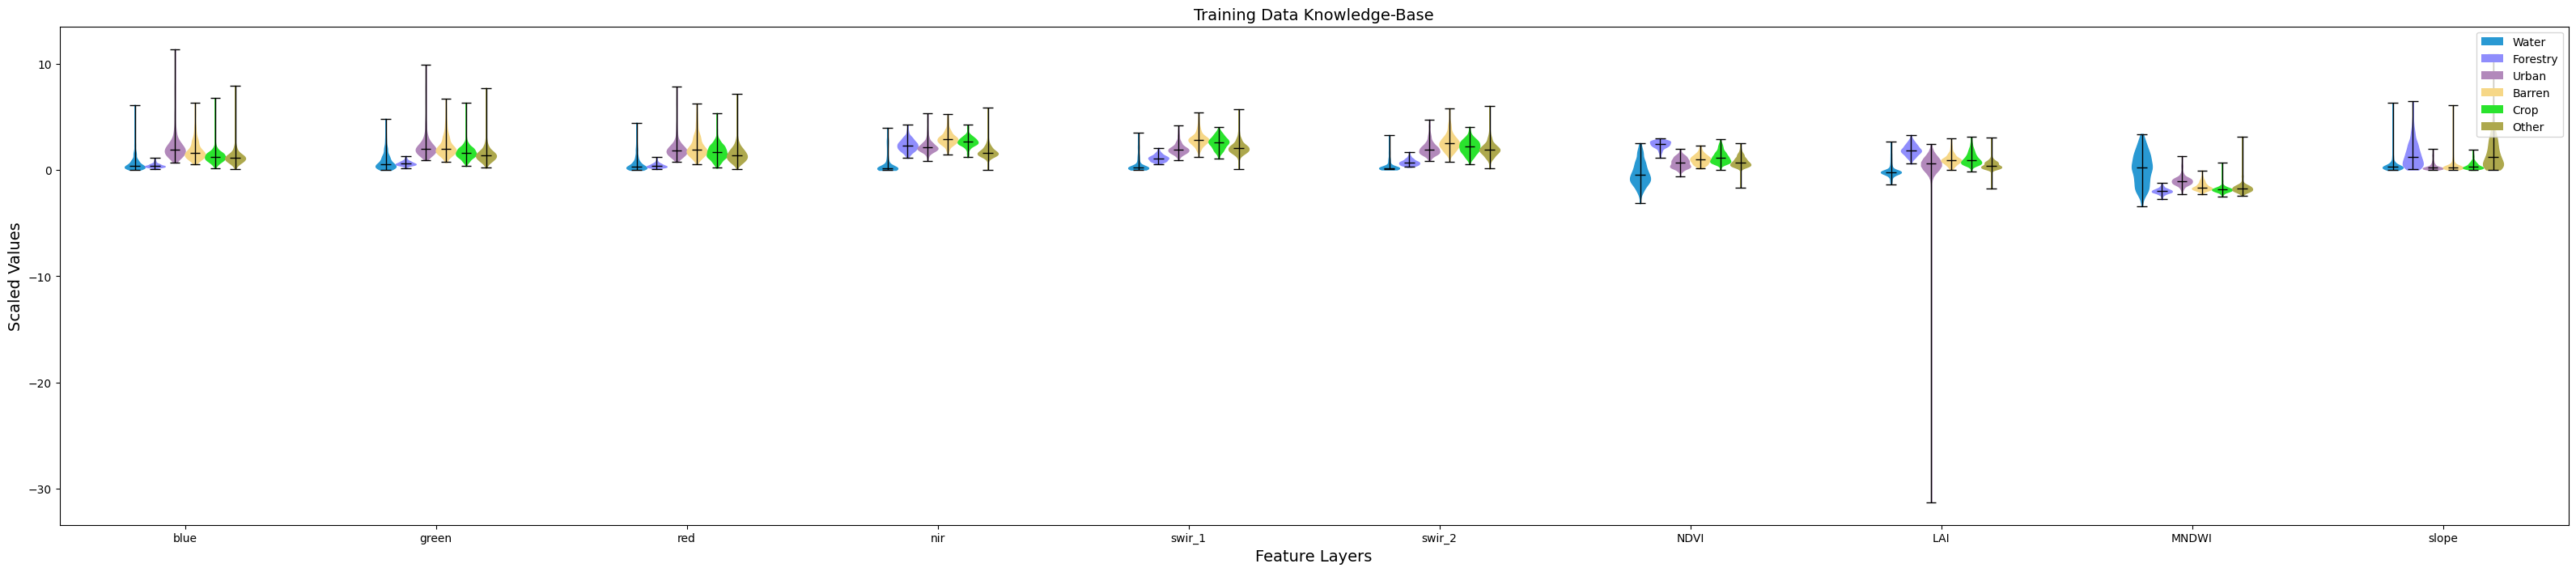

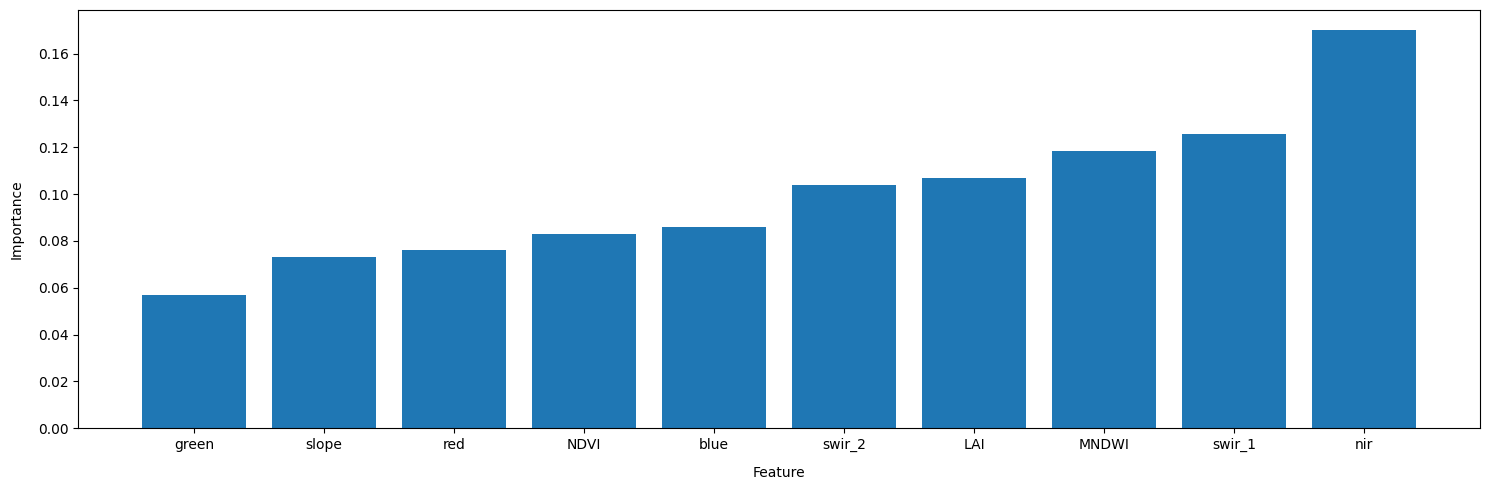

In [6]:
# Generate list of offsets & widths for plotting
start = -0.2
end = 0.2
offsets = list(np.linspace(start, end, len(dfs)))
if len(dfs) == 2:
    width = 0.4
else:
    width = np.abs(offsets[0] - offsets[1])

# Create figure and axes 
fig, ax = plt.subplots(figsize=(40, 8))

for key, color, offset in zip(dfs, colors, offsets):
    # Create violin plots
    pp = ax.violinplot(dfs[key].values,
                       showmedians=True,
                       positions=np.arange(dfs[key].values.shape[1]) + offset, widths=width
                      )
    # Change the color of the plots
    for pc in pp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)
    
    # Change the line style in the plots
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
        vp = pp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

# Tidy the plot, add a title and legend
ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5, len(column_names[1:]) - .5)
ax.set_ylabel("Scaled Values", fontsize=14)
ax.set_xlabel("Feature Layers", fontsize=14)
ax.set_title("Training Data Knowledge-Base", fontsize=14)
ax.legend([Patch(facecolor=c) for c in colors], [key for key in dfs], loc='upper right')

model = RandomForestClassifier(random_state=42)
model.fit(X, y.values.ravel())
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(15, 5))
plt.bar(x=np.array(column_names[1:])[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Feature', labelpad=10)
plt.tight_layout()

Variance explained by two principal components = 79.74 %
Variance explained by three principal components = 88.78 %


Text(0.5, 0, 'PC3')

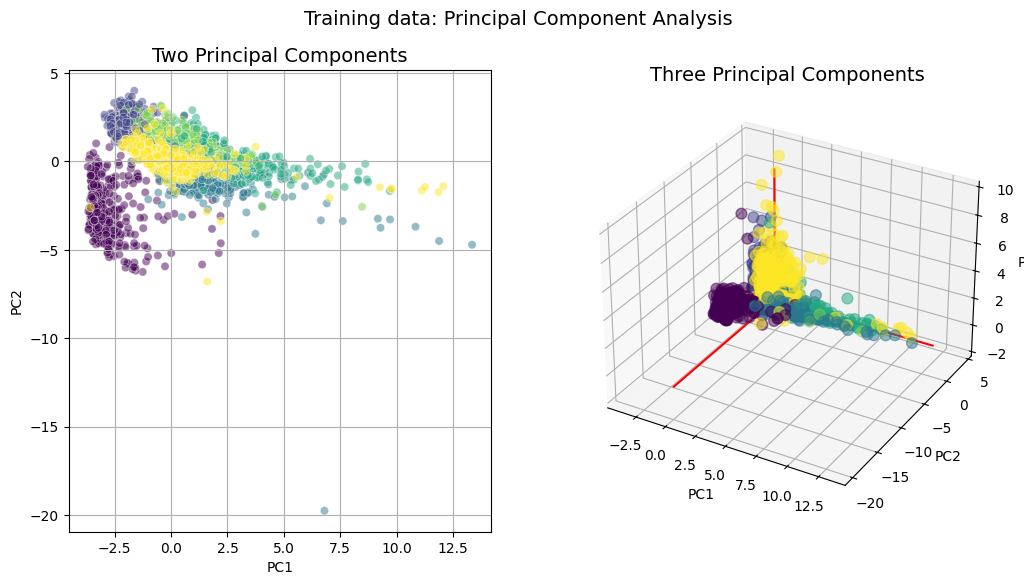

In [7]:
# Compute the mean and variance for each feature
X_scaled = scaler.transform(X)

# Two components PCA
pca2 = PCA(n_components=2)
pca2_fit = pca2.fit_transform(X_scaled)

# Three components PCA
pca3 = PCA(n_components=3)
pca3_fit = pca3.fit_transform(X_scaled)

# Add back to DataFrame
pca2_df = pd.DataFrame(data=pca2_fit, columns=['PC1', 'PC2'])
pca3_df = pd.DataFrame(data=pca3_fit, columns=['PC1', 'PC2', 'PC3'])

# Concatenate with classes
result2 = pd.concat([pca2_df, pd.DataFrame({'class': model_input[:, 0]})], axis=1)
result3 = pd.concat([pca3_df, pd.DataFrame({'class': model_input[:, 0]})], axis=1)

a2, b2 = pca2.explained_variance_ratio_
a3, b3, c3 = pca3.explained_variance_ratio_
print("Variance explained by two principal components = " + str(round((a2 + b2) * 100, 2)) + " %")
print("Variance explained by three principal components = " + str(round((a3 + b3 + c3) * 100, 2)) + " %")

if len(result2) > 5000:
    result2 = result2.sample(n=5000)
if len(result3) > 5000:
    result3 = result3.sample(n=5000)

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Training data: Principal Component Analysis', fontsize=14)

# First subplot
ax = fig.add_subplot(1, 2, 1)
scatter1 = sns.scatterplot(x="PC1", y="PC2",
                           data=result2,
                           hue='class',
                           palette='viridis',
                           legend=False,
                           alpha=0.5,
                           ax=ax)

ax.set_title('Two Principal Components', fontsize=14)
ax.grid(True)

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax.scatter(result3['PC1'], result3['PC2'], result3['PC3'],
                      c=result3['class'], s=60, alpha=0.5)

# Make simple, bare axis lines through space:
xAxisLine = ((min(result3['PC1']), max(result3['PC1'])), (0, 0), (0, 0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result3['PC2']), max(result3['PC2'])), (0, 0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0, 0), (min(result3['PC3']), max(result3['PC3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.set_title('Three Principal Components', fontsize=14)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")


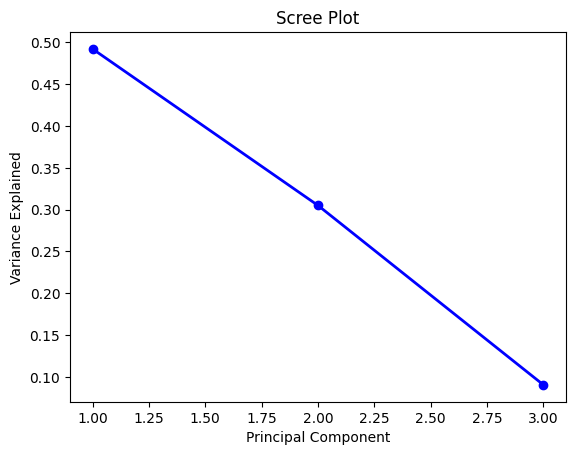

In [8]:
#scree plot (varience expected vs principal components)

PC_values = np.arange(pca3.n_components_) + 1
plt.plot(PC_values, pca3.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()